# Section 4.2.5. Diffusion Models (Denosing Diffusion Probabilistic Model)

"This implementation is inspired by the diffusion models presented in the Kaggle notebook [https://www.kaggle.com/code/setseries/diffusion-models-pytorch]."

In [1]:
import os
import math
import numpy as np

from tqdm.auto import tqdm
from functools import partial
from inspect import isfunction
import matplotlib.pyplot as plt
from einops import rearrange

import torch
from torch import nn, einsum
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader

from utils import *

torch.manual_seed(0)

In [2]:
# -------------------------------
# Define the UNet model
# -------------------------------
# Basic building blocks
def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()
    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)
        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift
        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )
        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()
    def forward(self, x, time_emb=None):
        h = self.block1(x)
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h
        h = self.block2(h)
        return h + self.res_conv(x)

class ConvNextBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )
        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)
        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()
    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)
        if exists(self.mlp) and exists(time_emb):
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")
        h = self.net(h)
        return h + self.res_conv(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)
    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv)
        q = q * self.scale
        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)
        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), nn.GroupNorm(1, dim))
    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv)
        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)
        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)
        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)
    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# UNet model
class Unet(nn.Module):
    def __init__(self, dim, init_dim=None, out_dim=None, dim_mults=(1, 2, 4, 8), channels=1, with_time_emb=True):
        super().__init__()
        self.channels = channels
        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        block_klass = partial(ConvNextBlock, mult=2)
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(
                nn.ModuleList([
                    block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                    block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                    Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                    Downsample(dim_out) if not is_last else nn.Identity(),
                ])
            )
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)
            self.ups.append(
                nn.ModuleList([
                    block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                    block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                    Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                    Upsample(dim_in) if not is_last else nn.Identity(),
                ])
            )
        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )
    def forward(self, x, time, cond=None):
        if cond == None:
            x = self.init_conv(x)
        else:
            x_raw = self.init_conv(x)
            cond = self.init_conv(cond)
            x = torch.concat([x_raw, cond], dim=1)
        t = self.time_mlp(time) if exists(self.time_mlp) else None
        h = []
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)
        return self.final_conv(x)

# Helper functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def get_noisy_image(x_start, t, reverse_transform, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    x_noisy = q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    noisy_image = reverse_transform(x_noisy.squeeze())
    return noisy_image

@torch.no_grad()
def p_sample(model, x, t, t_index, betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance, cond):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, cond) / sqrt_one_minus_alphas_cumprod_t)
    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def p_sample_loop(model, shape, betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance, timesteps, cond=None):
    device = next(model.parameters()).device
    b = shape[0]
    img = torch.randn(shape, device=device)
    imgs = []
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i,
                       betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance, cond)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size, channels, betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance, timesteps, cond=None):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size),
                         betas=betas, sqrt_recip_alphas=sqrt_recip_alphas,
                         sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod,
                         posterior_variance=posterior_variance, timesteps=timesteps, cond=cond)

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

## 1. Training Stage

In [3]:
# -------------------------------
# Loss function
# -------------------------------
def p_losses(denoise_model, x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise=None, cond=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)
    x_noisy = q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise=noise)
    predicted_noise = denoise_model(x_noisy, t, cond)
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()
    return loss

# -------------------------------
# Training
# -------------------------------
def train_ddpm_model(model, data_loader, optimizer, num_epochs, timesteps, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device, loss_type="huber"):
    model.train()
    for epoch in range(num_epochs):
        loss_list = []
        for step, batch in enumerate(data_loader):
            optimizer.zero_grad()
            batch_size = batch.shape[0]
            batch = batch[:, 0:1, :, :].float().to(device)
            t = torch.randint(0, timesteps, (batch_size,), device=device).long()
            loss = p_losses(model, batch, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, loss_type=loss_type)
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(loss_list)
        print(f'Epoch [{epoch+1:02}/{num_epochs}] Loss: {avg_loss:>6.4f}')
    return model


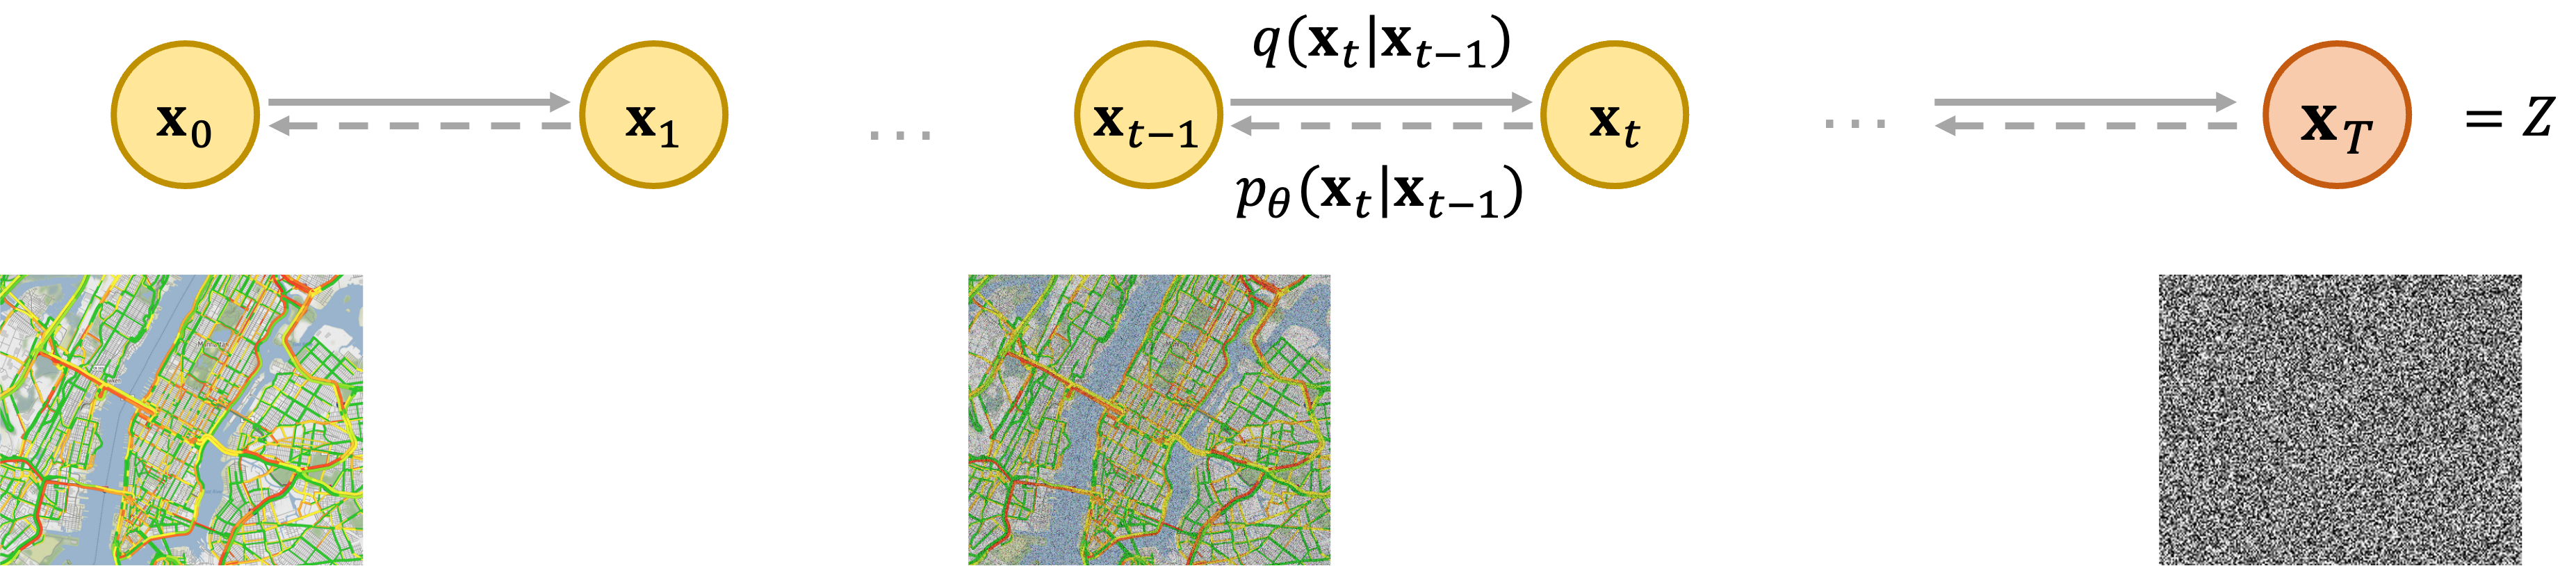

\begin{split}
L_{\text {simple }}=\mathbb{E}_{t, \mathbf{x}_0, \epsilon}\left[\left\|\epsilon-\epsilon_\theta\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t\right)\right\|_2^2\right]
\end{split}


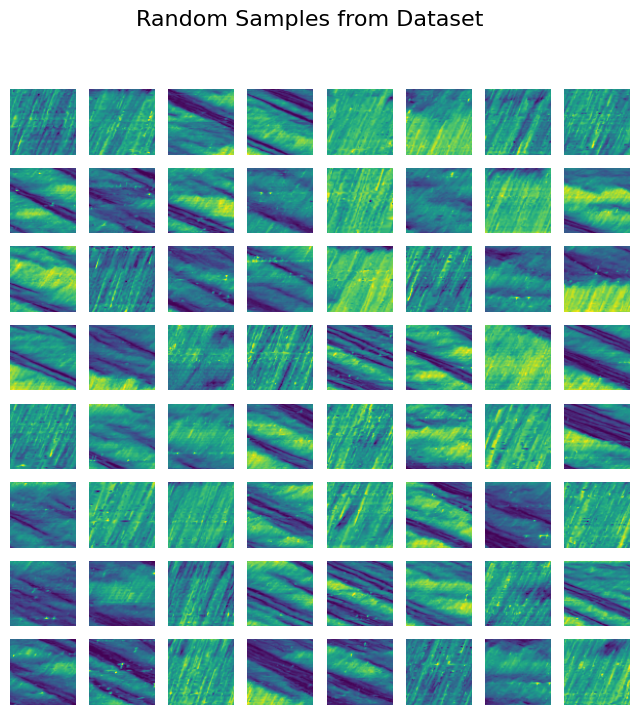

In [4]:
data_path = '../dataset/i24_normalized.pt' 
batch_size = 250
num_epochs = 10
timesteps = 500
lr = 0.0005
image_size = 64
channels = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset, data_loader = load_and_preprocess_data(data_path, batch_size)

betas = linear_beta_schedule(timesteps=timesteps).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas).to(device)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod).to(device)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

model = Unet(dim=image_size, channels=channels, dim_mults=(1, 2, 4,)).to(device)
optimizer = Adam(model.parameters(), lr=lr)

In [5]:
model = train_ddpm_model(model, data_loader, optimizer, num_epochs, timesteps, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device, loss_type="huber")

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), 'models/DDPM.pth')
print("Denoising Diffusion Probabilistic Models saved.")

Epoch [01/10] Loss: 0.2195
Epoch [02/10] Loss: 0.0268
Epoch [03/10] Loss: 0.0124
Epoch [04/10] Loss: 0.0106
Epoch [05/10] Loss: 0.0097
Epoch [06/10] Loss: 0.0094
Epoch [07/10] Loss: 0.0095
Epoch [08/10] Loss: 0.0092
Epoch [09/10] Loss: 0.0088
Epoch [10/10] Loss: 0.0088
Denoising Diffusion Probabilistic Models saved.


## 2. Testing Stage

In [6]:
def visualize_ddpm_samples(model, image_size, batch_size, channels, betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance, timesteps, save_path="img/DDPM_result.png"):
    model.eval()
    samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels,
                     betas=betas, sqrt_recip_alphas=sqrt_recip_alphas,
                     sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod,
                     posterior_variance=posterior_variance, timesteps=timesteps)
    sample_list = samples[-1]
    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            ax[i, j].imshow(sample_list[i * 8 + j][0, :, :], origin="lower", cmap="viridis")
            ax[i, j].axis("off")
    plt.savefig(save_path, dpi=500)
    plt.show()
    plt.close()


sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

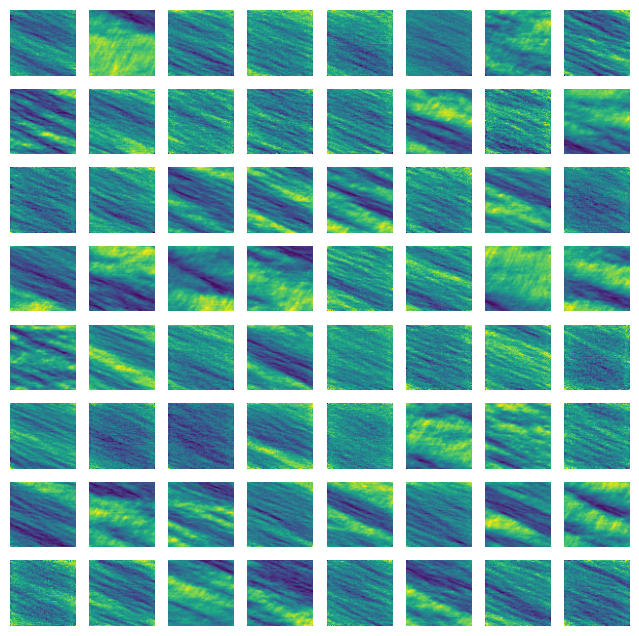

In [8]:
# Can use CPU in the inference, but highly recommended to use GPU
# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Unet(dim=image_size, channels=channels, dim_mults=(1, 2, 4,)).to(device)
model.load_state_dict(torch.load('models/DDPM.pth', map_location=device))
model.eval()

os.makedirs("img", exist_ok=True)
visualize_ddpm_samples(model, image_size=image_size, batch_size=64, channels=channels,
                        betas=betas, sqrt_recip_alphas=sqrt_recip_alphas,
                        sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod,
                        posterior_variance=posterior_variance, timesteps=timesteps,
                        save_path="img/DDPM_result.png")